In [13]:
import pandas as pd
import seaborn as sns
import numpy as np
from MakePlots import *
import os
import random
from scipy import stats
from itertools import groupby,combinations
from scipy.optimize import curve_fit
from scipy.stats import t
import statsmodels.api as sm

In [14]:
def quadratic_function(x, a, b, c):
        return a * x**2 + b * x + c

In [ ]:
analysis_dir = Path('/path/to/AnalysisAndFigures-Final')
figure_dir = analysis_dir/'SpecializedPlots'
if not os.path.isdir(figure_dir):
    os.mkdir(figure_dir)

operator_for_average = '75pct'

patient_key = pd.read_excel('PatientKey.xlsx')
family1_df = pd.read_csv(analysis_dir/'Rank_Ordered_Barplots'/operator_for_average/f'3.1.0_{operator_for_average}_Family_Clusters_Renamed.tsv',
                        delimiter='\t')

In [16]:
def reformat_average_tel_len(row,sibling_id_list,avg_str):
    allele_id = row['plot_allele_id']
    data = []
    for sibling_id in sibling_id_list:
        lengths = get_tel_len_list(row[f'{sibling_id}_read_TLs'],True,row[f'{sibling_id}_tvr_len'])
        avg_len = find_average(lengths,avg_str)
        if avg_len>0:
            data.append([allele_id,sibling_id,avg_len,row['allele_class']])
    tdf = pd.DataFrame(data=data,columns=['allele_id','sample_id',f'{avg_str}_tel_len','allele_class'])
    return tdf

In [17]:
siblings_key = patient_key[patient_key['Patient#']==1]
siblings_key = siblings_key[siblings_key['SiblingGroup']==2]
carrier_parent = unique(siblings_key.CarrierParent.tolist())[0]
non_carrier_parent = unique(siblings_key.NonCarrierParent.tolist())[0]

relevant_columns = ['plot_allele_id']+[x for x in family1_df.columns if x.split('_')[0] in siblings_key['Sample'].tolist()+[carrier_parent,non_carrier_parent]]
sibling_df = family1_df[relevant_columns].copy()
sibling_df['allele_class'] = 'Uncertain'
carrier_inds=non_carrier_inds=[]
if str(carrier_parent) != 'nan':
    carrier_inds = sibling_df[sibling_df[f'{carrier_parent}_tvr_consensus'].apply(lambda x: str(x)!='nan')].index
    sibling_df.loc[carrier_inds,'allele_class'] = 'Carrier'
if str(non_carrier_parent) != 'nan':
    non_carrier_inds = sibling_df[sibling_df[f'{non_carrier_parent}_tvr_consensus'].apply(lambda x: str(x)!='nan')].index
    sibling_df.loc[non_carrier_inds,'allele_class'] = 'NonCarrier'
shared_inds = [x for x in carrier_inds if x in non_carrier_inds]
sibling_df.loc[shared_inds,'allele_class'] = 'Uncertain'

In [18]:
sibling_columns = ['plot_allele_id','allele_class']+[x for x in family1_df.columns if x.split('_')[0] in siblings_key['Sample'].tolist()]
sibling_df = sibling_df[sibling_columns].copy()
sibling_df['patients_per_cluster'] = sibling_df.apply(lambda x: sum([str(x[f'{y}_tvr_consensus'])!='nan' for y in siblings_key['Sample'].tolist()]),axis=1)
#subset df to just include alleles that are present in at least 2 sibling samples
sibling_df = sibling_df[sibling_df['patients_per_cluster']>1].copy()
print(f'{len(sibling_df)} alleles identified in common between at least two siblings')

135 alleles identified in common between at least two siblings


In [19]:
sibling_ids = siblings_key.Sample.tolist()
for patient_id in sibling_ids:
    sibling_df[f'{patient_id}_total_tel_len'] = sibling_df.apply(lambda x: get_tel_len_list(x[f'{patient_id}_read_TLs'],True,x[f'{patient_id}_tvr_len']),axis=1)
    sibling_df[f'{patient_id}_{operator_for_average}_tel_len'] = sibling_df[f'{patient_id}_total_tel_len'].apply(lambda x: find_average(x,operator_for_average))
    sibling_df[f'{patient_id}_{operator_for_average}_tel_std_dev'] = sibling_df[f'{patient_id}_total_tel_len'].apply(lambda x: np.std(x))

In [20]:
from itertools import combinations
nephews_ro_df = []

all_sibling_pairs = list(combinations(sibling_ids, 2))
for sibling_pair in all_sibling_pairs:
    plot_name = f'{patient_key[patient_key.Sample==sibling_pair[0]]['FigureName'].item()} vs {patient_key[patient_key.Sample==sibling_pair[1]]['FigureName'].item()}'
    comparison_type = [patient_key[patient_key.Sample==x].caPOT1Status.item() for x in sibling_pair]
    if '-' in comparison_type and '+' in comparison_type:
        comparison_type = 'Mixed'
    elif unique(comparison_type)==['-']:
        comparison_type = 'Negative'
    elif unique(comparison_type)==['+']:
        comparison_type = 'Positive'
    else:
        print('Error with comparison type!!')
    rel_cols = ['allele_class','plot_allele_id']+[x for x in sibling_df.columns if x.split('_')[0] in sibling_pair]
    tdf = sibling_df.copy().dropna(subset=[f'{sibling_pair[0]}_tvr_consensus',f'{sibling_pair[1]}_tvr_consensus'])[rel_cols].copy()
    tdf = tdf.sort_values(by=f'{sibling_pair[0]}_{operator_for_average}_tel_len')
    tdf['x_nephew_ro'] = [x for x in range(len(tdf))]
    tdf = tdf.sort_values(by=f'{sibling_pair[1]}_{operator_for_average}_tel_len')
    tdf['y_nephew_ro'] = [x for x in range(len(tdf))]
    tdf.rename(columns={f'{sibling_pair[0]}_{operator_for_average}_tel_len':'x_nephew_tel_len',
                        f'{sibling_pair[1]}_{operator_for_average}_tel_len':'y_nephew_tel_len'},inplace=True)
    tdf['x_nephew_id'] = sibling_pair[0]
    tdf['y_nephew_id'] = sibling_pair[1]
    tdf['comparison_type'] = comparison_type
    tdf['plot_name'] = plot_name


    cols_for_plot = ['allele_class','plot_allele_id','comparison_type','plot_name'] +[x for x in tdf.columns if 'nephew' in x]
    tdf = tdf[cols_for_plot].copy()
    nephews_ro_df.append(tdf)
nephews_ro_df = pd.concat(nephews_ro_df)


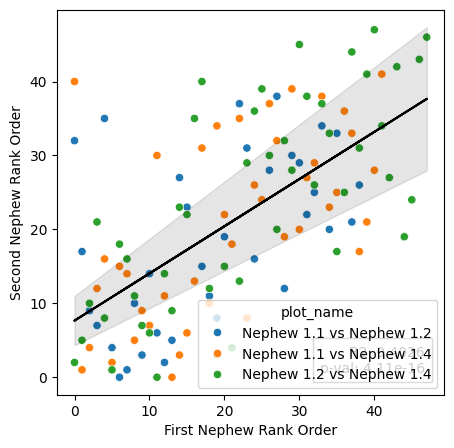

In [21]:
#plot just the non-carrier nephews together
file_prefix = 'fam1_negative_nephews_RO_fit'
with open(figure_dir/f'{file_prefix}_regression_stats.txt', 'w') as f:
        pass

fig,ax = plt.subplots(figsize = (5,5))
plot_ro_df = nephews_ro_df[nephews_ro_df.comparison_type=='Negative'].copy()
i=sns.scatterplot(data=plot_ro_df,x='x_nephew_ro',y='y_nephew_ro',hue='plot_name')

x_data = plot_ro_df.x_nephew_ro.tolist()
y_data = plot_ro_df.y_nephew_ro.tolist()
# Fit OLS model with intercept
const_x = sm.add_constant(x_data, prepend=False)
model = sm.OLS(y_data, const_x)
results = model.fit()
params = results.params
ax.plot(x_data, [x * params[0] + params[1] for x in x_data],color='black')

with open(figure_dir/f'{file_prefix}_regression_stats.txt', 'a') as f:
        f.write(results.summary().as_text())

x_data.sort()
confidence_intervals = results.conf_int(alpha=0.05)
lower_bounds = [x * confidence_intervals[0,0] + confidence_intervals[1,0] for x in x_data]
upper_bounds = [x * confidence_intervals[0,1] + confidence_intervals[1,1] for x in x_data]
k = plt.fill_between(x_data,lower_bounds,upper_bounds,color='black',alpha=0.1)

p_value = results.f_pvalue
if p_value <0.01:
        p_value = "{:.2e}".format(p_value)
else:
        p_value = round(p_value,4)
text_content = f"R2: {round(results.rsquared_adj,4)}\np-val: {p_value}"
ax.text(0.95, 0.05, text_content, transform=ax.transAxes, ha='right', va='bottom',
        bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 5})

ax.set_xlabel('First Nephew Rank Order')
ax.set_ylabel('Second Nephew Rank Order')
plt.show()
fig.savefig(figure_dir/f'{file_prefix}.png',bbox_inches='tight')
fig.savefig(figure_dir/f'{file_prefix}_transparent.png',bbox_inches='tight',transparent=True)
svg_path = figure_dir/f'{file_prefix}.svg'
ai_path = figure_dir/f'{file_prefix}.ai'
plt.rcParams['svg.fonttype'] = 'none'
# Save the figure as an SVG file
fig.savefig(svg_path, format="svg",bbox_inches='tight')
# Convert the SVG file to AI format
cairosvg.svg2pdf(url=str(svg_path), write_to=str(ai_path))
plt.close()

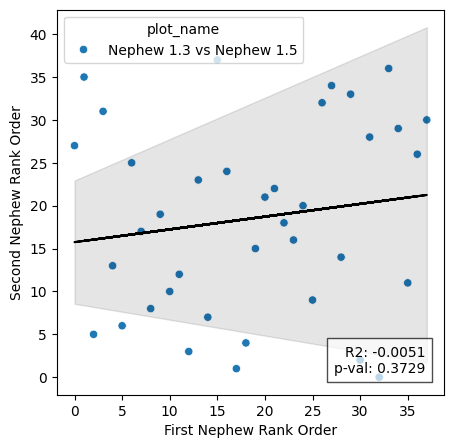

In [22]:
#plot just the carrier nephews together
file_prefix = 'fam1_positive_nephews_RO_fit'
with open(figure_dir/f'{file_prefix}_regression_stats.txt', 'w') as f:
        pass

fig,ax = plt.subplots(figsize = (5,5))
plot_ro_df = nephews_ro_df[nephews_ro_df.comparison_type=='Positive'].copy()
i=sns.scatterplot(data=plot_ro_df,x='x_nephew_ro',y='y_nephew_ro',hue='plot_name')

x_data = plot_ro_df.x_nephew_ro.tolist()
y_data = plot_ro_df.y_nephew_ro.tolist()
# Fit OLS model with intercept
const_x = sm.add_constant(x_data, prepend=False)
model = sm.OLS(y_data, const_x)
results = model.fit()
params = results.params
ax.plot(x_data, [x * params[0] + params[1] for x in x_data],color='black')

with open(figure_dir/f'{file_prefix}_regression_stats.txt', 'a') as f:
        f.write(results.summary().as_text())

x_data.sort()
confidence_intervals = results.conf_int(alpha=0.05)
lower_bounds = [x * confidence_intervals[0,0] + confidence_intervals[1,0] for x in x_data]
upper_bounds = [x * confidence_intervals[0,1] + confidence_intervals[1,1] for x in x_data]
k = plt.fill_between(x_data,lower_bounds,upper_bounds,color='black',alpha=0.1)

p_value = results.f_pvalue
if p_value <0.01:
        p_value = "{:.2e}".format(p_value)
else:
        p_value = round(p_value,4)
text_content = f"R2: {round(results.rsquared_adj,4)}\np-val: {p_value}"
ax.text(0.95, 0.05, text_content, transform=ax.transAxes, ha='right', va='bottom',
        bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 5})

ax.set_xlabel('First Nephew Rank Order')
ax.set_ylabel('Second Nephew Rank Order')
plt.show()
fig.savefig(figure_dir/f'{file_prefix}.png',bbox_inches='tight')
fig.savefig(figure_dir/f'{file_prefix}_transparent.png',bbox_inches='tight',transparent=True)
svg_path = figure_dir/f'{file_prefix}.svg'
ai_path = figure_dir/f'{file_prefix}.ai'
plt.rcParams['svg.fonttype'] = 'none'
# Save the figure as an SVG file
fig.savefig(svg_path, format="svg",bbox_inches='tight')
# Convert the SVG file to AI format
cairosvg.svg2pdf(url=str(svg_path), write_to=str(ai_path))
plt.close()

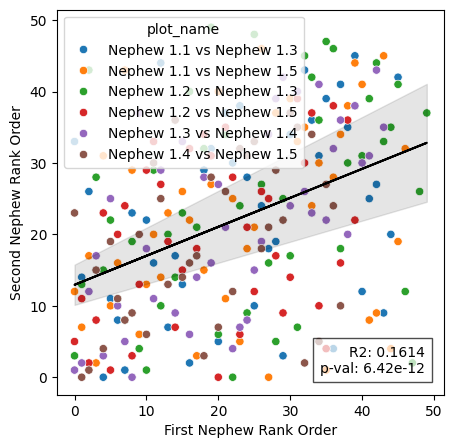

<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

In [23]:
#plot just the mixed comparisons  together
file_prefix = 'fam1_mixed_nephews_RO_fit'
with open(figure_dir/f'{file_prefix}_regression_stats.txt', 'w') as f:
        pass

fig,ax = plt.subplots(figsize = (5,5))
plot_ro_df = nephews_ro_df[nephews_ro_df.comparison_type=='Mixed'].copy()
i=sns.scatterplot(data=plot_ro_df,x='x_nephew_ro',y='y_nephew_ro',hue='plot_name')

x_data = plot_ro_df.x_nephew_ro.tolist()
y_data = plot_ro_df.y_nephew_ro.tolist()
# Fit OLS model with intercept
const_x = sm.add_constant(x_data, prepend=False)
model = sm.OLS(y_data, const_x)
results = model.fit()
params = results.params
ax.plot(x_data, [x * params[0] + params[1] for x in x_data],color='black')

with open(figure_dir/f'{file_prefix}_regression_stats.txt', 'a') as f:
        f.write(results.summary().as_text())

x_data.sort()
confidence_intervals = results.conf_int(alpha=0.05)
lower_bounds = [x * confidence_intervals[0,0] + confidence_intervals[1,0] for x in x_data]
upper_bounds = [x * confidence_intervals[0,1] + confidence_intervals[1,1] for x in x_data]
k = plt.fill_between(x_data,lower_bounds,upper_bounds,color='black',alpha=0.1)

p_value = results.f_pvalue
if p_value <0.01:
        p_value = "{:.2e}".format(p_value)
else:
        p_value = round(p_value,4)
text_content = f"R2: {round(results.rsquared_adj,4)}\np-val: {p_value}"
ax.text(0.95, 0.05, text_content, transform=ax.transAxes, ha='right', va='bottom',
        bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 5})

ax.set_xlabel('First Nephew Rank Order')
ax.set_ylabel('Second Nephew Rank Order')
plt.show()
fig.savefig(figure_dir/f'{file_prefix}.png',bbox_inches='tight')
fig.savefig(figure_dir/f'{file_prefix}_transparent.png',bbox_inches='tight',transparent=True)
svg_path = figure_dir/f'{file_prefix}.svg'
ai_path = figure_dir/f'{file_prefix}.ai'
plt.rcParams['svg.fonttype'] = 'none'
# Save the figure as an SVG file
fig.savefig(svg_path, format="svg",bbox_inches='tight')
# Convert the SVG file to AI format
cairosvg.svg2pdf(url=str(svg_path), write_to=str(ai_path))
plt.close

Repeat above plots but aligning to the order of the maternal alleles

In [24]:
relevant_ids = sibling_ids + [carrier_parent]
relevant_columns = ['plot_allele_id']+[x for x in family1_df.columns if x.split('_')[0] in relevant_ids]
nephew_sister_df = family1_df[relevant_columns].copy()
nephew_sister_df['#patients'] = nephew_sister_df.apply(lambda x: sum([str(x[f'{id}_tvr_consensus'])!='nan' for id in relevant_ids]),axis=1)
nephew_sister_df = nephew_sister_df[nephew_sister_df['#patients']>0].reset_index()
for patient_id in relevant_ids:
    nephew_sister_df[f'{patient_id}_total_tel_len'] = nephew_sister_df.apply(lambda x: get_tel_len_list(x[f'{patient_id}_read_TLs'],True,x[f'{patient_id}_tvr_len']),axis=1)
    nephew_sister_df[f'{patient_id}_{operator_for_average}_tel_len'] = nephew_sister_df[f'{patient_id}_total_tel_len'].apply(lambda x: find_average(x,operator_for_average))
    nephew_sister_df[f'{patient_id}_{operator_for_average}_tel_std_dev'] = nephew_sister_df[f'{patient_id}_total_tel_len'].apply(lambda x: np.std(x))


In [25]:
comparison_dict = {'-':'Negative','+':'Positive'}
nephew_sis_ro_df = []
for nephew_id in sibling_ids:
    plot_name = patient_key[patient_key.Sample==nephew_id]['FigureName'].item()
    comparison_type = comparison_dict[patient_key[patient_key.Sample==nephew_id].caPOT1Status.item()]

    rel_cols = ['plot_allele_id']+[x for x in nephew_sister_df.columns if x.split('_')[0] in [nephew_id,carrier_parent]]
    tdf = nephew_sister_df.copy().dropna(subset=[f'{nephew_id}_tvr_consensus',f'{carrier_parent}_tvr_consensus'])[rel_cols].copy()
    tdf = tdf.sort_values(by=f'{nephew_id}_{operator_for_average}_tel_len')
    tdf['nephew_ro'] = [x for x in range(len(tdf))]
    tdf = tdf.sort_values(by=f'{carrier_parent}_{operator_for_average}_tel_len')
    tdf['maternal_ro'] = [x for x in range(len(tdf))]
    tdf.rename(columns={f'{nephew_id}_{operator_for_average}_tel_len':'nephew_tel_len',
                        f'{carrier_parent}_{operator_for_average}_tel_len':'maternal_tel_len'},inplace=True)
    tdf['nephew_id'] = nephew_id
    tdf['maternal_id'] = carrier_parent
    tdf['comparison_type'] = comparison_type
    tdf['plot_name'] = plot_name

    cols_for_plot = ['plot_allele_id','comparison_type','plot_name'] +[x for x in tdf.columns if 'nephew' in x or 'maternal' in x]
    tdf = tdf[cols_for_plot].copy()
    nephew_sis_ro_df.append(tdf)
nephew_sis_ro_df = pd.concat(nephew_sis_ro_df)

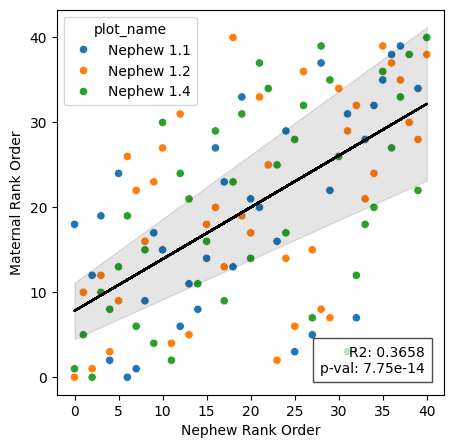

In [26]:
#plot just the non-carrier nephews together
file_prefix = 'fam1_negative_sis-neph_RO_fit'
with open(figure_dir/f'{file_prefix}_regression_stats.txt', 'w') as f:
        pass

fig,ax = plt.subplots(figsize = (5,5))
plot_ro_df = nephew_sis_ro_df[nephew_sis_ro_df.comparison_type=='Negative'].copy()
i=sns.scatterplot(data=plot_ro_df,x='nephew_ro',y='maternal_ro',hue='plot_name')

x_data = plot_ro_df.nephew_ro.tolist()
y_data = plot_ro_df.maternal_ro.tolist()
# Fit OLS model with intercept
const_x = sm.add_constant(x_data, prepend=False)
model = sm.OLS(y_data, const_x)
results = model.fit()
params = results.params
ax.plot(x_data, [x * params[0] + params[1] for x in x_data],color='black')

with open(figure_dir/f'{file_prefix}_regression_stats.txt', 'a') as f:
        f.write(results.summary().as_text())

x_data.sort()
confidence_intervals = results.conf_int(alpha=0.05)
lower_bounds = [x * confidence_intervals[0,0] + confidence_intervals[1,0] for x in x_data]
upper_bounds = [x * confidence_intervals[0,1] + confidence_intervals[1,1] for x in x_data]
k = plt.fill_between(x_data,lower_bounds,upper_bounds,color='black',alpha=0.1)

p_value = results.f_pvalue
if p_value <0.01:
        p_value = "{:.2e}".format(p_value)
else:
        p_value = round(p_value,4)
text_content = f"R2: {round(results.rsquared_adj,4)}\np-val: {p_value}"
ax.text(0.95, 0.05, text_content, transform=ax.transAxes, ha='right', va='bottom',
        bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 5})

ax.set_xlabel('Nephew Rank Order')
ax.set_ylabel('Maternal Rank Order')
plt.show()
fig.savefig(figure_dir/f'{file_prefix}.png',bbox_inches='tight')
fig.savefig(figure_dir/f'{file_prefix}_transparent.png',bbox_inches='tight',transparent=True)
svg_path = figure_dir/f'{file_prefix}.svg'
ai_path = figure_dir/f'{file_prefix}.ai'
plt.rcParams['svg.fonttype'] = 'none'
# Save the figure as an SVG file
fig.savefig(svg_path, format="svg",bbox_inches='tight')
# Convert the SVG file to AI format
cairosvg.svg2pdf(url=str(svg_path), write_to=str(ai_path))

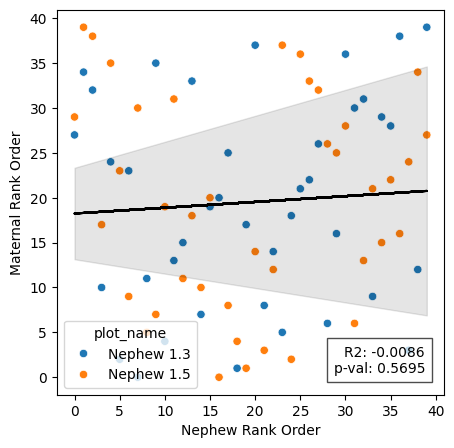

In [27]:
#plot just the carrier nephews together
file_prefix = 'fam1_positive_sis-neph_RO_fit'
with open(figure_dir/f'{file_prefix}_regression_stats.txt', 'w') as f:
        pass

fig,ax = plt.subplots(figsize = (5,5))
plot_ro_df = nephew_sis_ro_df[nephew_sis_ro_df.comparison_type=='Positive'].copy()
i=sns.scatterplot(data=plot_ro_df,x='nephew_ro',y='maternal_ro',hue='plot_name')

x_data = plot_ro_df.nephew_ro.tolist()
y_data = plot_ro_df.maternal_ro.tolist()
# Fit OLS model with intercept
const_x = sm.add_constant(x_data, prepend=False)
model = sm.OLS(y_data, const_x)
results = model.fit()
params = results.params
ax.plot(x_data, [x * params[0] + params[1] for x in x_data],color='black')

with open(figure_dir/f'{file_prefix}_regression_stats.txt', 'a') as f:
        f.write(results.summary().as_text())

x_data.sort()
confidence_intervals = results.conf_int(alpha=0.05)
lower_bounds = [x * confidence_intervals[0,0] + confidence_intervals[1,0] for x in x_data]
upper_bounds = [x * confidence_intervals[0,1] + confidence_intervals[1,1] for x in x_data]
k = plt.fill_between(x_data,lower_bounds,upper_bounds,color='black',alpha=0.1)

p_value = results.f_pvalue
if p_value <0.01:
        p_value = "{:.2e}".format(p_value)
else:
        p_value = round(p_value,4)
text_content = f"R2: {round(results.rsquared_adj,4)}\np-val: {p_value}"
ax.text(0.95, 0.05, text_content, transform=ax.transAxes, ha='right', va='bottom',
        bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 5})

ax.set_xlabel('Nephew Rank Order')
ax.set_ylabel('Maternal Rank Order')
plt.show()
fig.savefig(figure_dir/f'{file_prefix}.png',bbox_inches='tight')
fig.savefig(figure_dir/f'{file_prefix}_transparent.png',bbox_inches='tight',transparent=True)
svg_path = figure_dir/f'{file_prefix}.svg'
ai_path = figure_dir/f'{file_prefix}.ai'
plt.rcParams['svg.fonttype'] = 'none'
# Save the figure as an SVG file
fig.savefig(svg_path, format="svg",bbox_inches='tight')
# Convert the SVG file to AI format
cairosvg.svg2pdf(url=str(svg_path), write_to=str(ai_path))

Now transition to standard deviation and telomere length changes

In [ ]:
capot1_dict = {'+':'Positive','-':'Negative'}
nephews_std_dev_df = []
for id in sibling_ids:
    temp_std_dev = sibling_df[['allele_class','plot_allele_id',f'{id}_{operator_for_average}_tel_len',
                f'{id}_{operator_for_average}_tel_std_dev']].copy()
    temp_std_dev['sample_id'] = id
    temp_std_dev['nephew_pot1_mut_status'] = capot1_dict[siblings_key[siblings_key.Sample==id]['caPOT1Status'].item()]
    temp_std_dev['figure_name'] = patient_key[patient_key.Sample==id]['FigureName'].item()
    temp_std_dev.rename(columns={f'{id}_{operator_for_average}_tel_len':f'{operator_for_average}_tel_len',
                                f'{id}_{operator_for_average}_tel_std_dev':'tel_std_dev'},inplace=True)
    temp_std_dev.dropna(subset=f'{operator_for_average}_tel_len',inplace=True)
    nephews_std_dev_df.append(temp_std_dev)
nephews_std_dev_df = pd.concat(nephews_std_dev_df)

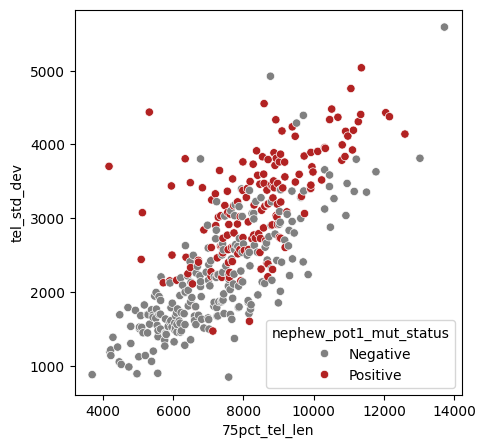

In [60]:
file_prefix = 'fam1_nephews_std_dev_scatter'

fig,ax = plt.subplots(figsize = (5,5))
i=sns.scatterplot(data=nephews_std_dev_df,x=f'{operator_for_average}_tel_len',y='tel_std_dev',hue='nephew_pot1_mut_status',
                  hue_order=['Negative','Positive'],palette=['grey','firebrick'])

plt.show()
fig.savefig(figure_dir/f'{file_prefix}.png',bbox_inches='tight')
fig.savefig(figure_dir/f'{file_prefix}_transparent.png',bbox_inches='tight',transparent=True)
svg_path = figure_dir/f'{file_prefix}.svg'
ai_path = figure_dir/f'{file_prefix}.ai'
plt.rcParams['svg.fonttype'] = 'none'
# Save the figure as an SVG file
fig.savefig(svg_path, format="svg",bbox_inches='tight')
# Convert the SVG file to AI format
cairosvg.svg2pdf(url=str(svg_path), write_to=str(ai_path))
plt.close()

    

[7.04738439e-06 1.13829233e-01 4.48766727e+02]


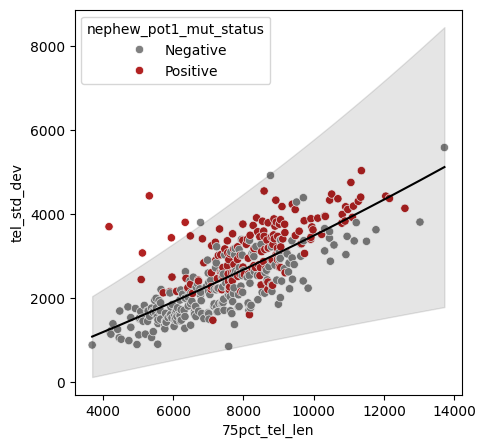

In [61]:
file_prefix = 'fam1_nephews_std_dev_fit'
with open(figure_dir/f'{file_prefix}_regression_stats.txt', 'w') as f:
        pass

fig,ax = plt.subplots(figsize = (5,5))
i=sns.scatterplot(data=nephews_std_dev_df,x=f'{operator_for_average}_tel_len',y='tel_std_dev',hue='nephew_pot1_mut_status',
                  hue_order=['Negative','Positive'],palette=['grey','firebrick'])
#attempt to fit a quadratic for each of the conditions
colors_dict = {'Positive':'tab:orange','Negative':'tab:blue'}

x_data = nephews_std_dev_df[f'{operator_for_average}_tel_len'].tolist()
y_data = nephews_std_dev_df['tel_std_dev'].tolist()

popt, pcov = curve_fit(quadratic_function, x_data, y_data, p0=(0, 2, 1000))
a_fit, b_fit, c_fit = popt


perr = np.sqrt(np.diagonal(pcov))
print(perr)
x_data.sort()
y_fit_line = [quadratic_function(x, *popt) for x in x_data]
upper_bounds = [quadratic_function(x, *(popt+perr)) for x in x_data]
lower_bounds = [quadratic_function(x, *(popt-perr)) for x in x_data]
with open(figure_dir/f'{file_prefix}_regression_stats.txt', 'a') as f:
    f.write(f"Fitted parameters: a={a_fit:.2f}, b={b_fit:.2f}, c={c_fit:.2f}\n")
    f.write(f'Sqrt diag Covariance matrix: {perr}')

j = plt.plot(x_data, y_fit_line, color='black', label='Fitted Curve')
k = plt.fill_between(x_data,lower_bounds,upper_bounds,color='black',alpha=0.1)

plt.show()
fig.savefig(figure_dir/f'{file_prefix}.png',bbox_inches='tight')
fig.savefig(figure_dir/f'{file_prefix}_transparent.png',bbox_inches='tight',transparent=True)
svg_path = figure_dir/f'{file_prefix}.svg'
ai_path = figure_dir/f'{file_prefix}.ai'
plt.rcParams['svg.fonttype'] = 'none'
# Save the figure as an SVG file
fig.savefig(svg_path, format="svg",bbox_inches='tight')
# Convert the SVG file to AI format
cairosvg.svg2pdf(url=str(svg_path), write_to=str(ai_path))
plt.close()

    

In [20]:
nephews_std_dev_df['tel_len_bins'] = nephews_std_dev_df[f'{operator_for_average}_tel_len'].apply(lambda x: f'{int(np.floor(x/1000)*1000)}-\n{int(np.ceil(x/1000)*1000)}')
#check to see there are at least 10 datapoints in each bin, otherwise exclude
bins_to_use = [x for x in unique(nephews_std_dev_df.tel_len_bins.tolist()) if len(nephews_std_dev_df[nephews_std_dev_df.tel_len_bins==x])>=10]
nephews_std_dev_df['plot_bins'] = nephews_std_dev_df.tel_len_bins.apply(lambda x: x in bins_to_use)
nephews_std_dev_df.sort_values(by=f'{operator_for_average}_tel_len',inplace=True)

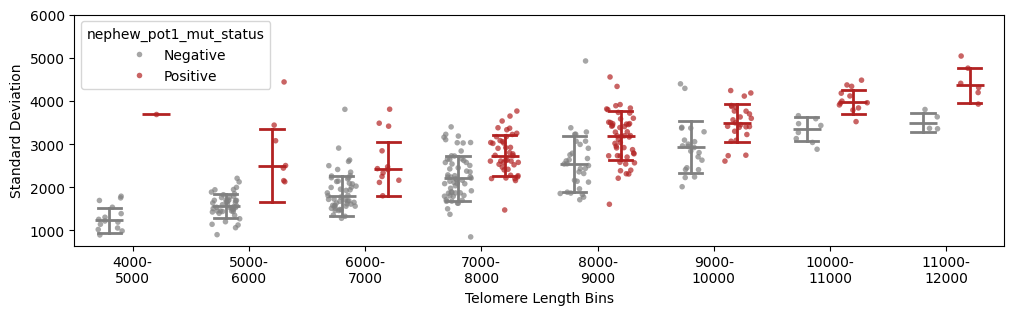

In [66]:
file_prefix = 'fam1_nephews_std_dev_binned'
with open(figure_dir/f'{file_prefix}_ttest_stats.txt', 'w') as f:
        f.write("Using Welch's t-test for each bin...\n")
fig,ax = plt.subplots(figsize = (12,3))
i=sns.stripplot(data=nephews_std_dev_df[nephews_std_dev_df.plot_bins],x='tel_len_bins',y='tel_std_dev', size=4, alpha=0.70,
              hue='nephew_pot1_mut_status',hue_order=['Negative','Positive'],palette=['grey','firebrick'],dodge=0.2,jitter=0.25,zorder=0)
j=sns.pointplot(data=nephews_std_dev_df[nephews_std_dev_df.plot_bins],x='tel_len_bins', y='tel_std_dev',
                hue='nephew_pot1_mut_status',hue_order=['Negative','Positive'],
                errorbar='sd',capsize=.2,linestyle="none",palette=['grey','firebrick'],linewidth=2,estimator=np.median,
                marker="_", markersize=20, markeredgewidth=2,dodge=0.4,legend=False)
ax.set_ylim(min(nephews_std_dev_df.tel_std_dev.tolist())-200,6000)

with open(figure_dir/f'{file_prefix}_ttest_stats.txt', 'a') as f:
    for bin in unique(nephews_std_dev_df.tel_len_bins.tolist()):
        if bin not in bins_to_use:
            f.write(f'Bin {bin.replace('\n','')}: too few samples to test\n\n')
            continue
        tdf = nephews_std_dev_df[nephews_std_dev_df.tel_len_bins==bin]
        positive_samples = tdf[tdf.nephew_pot1_mut_status=='Positive']['tel_std_dev'].tolist()
        negative_samples = tdf[tdf.nephew_pot1_mut_status=='Negative']['tel_std_dev'].tolist()
        t_statistic,p_value = stats.ttest_ind(positive_samples,negative_samples,equal_var=False)
        f.write(f'Bin {bin.replace('\n','')}:\n')
        f.write(f"T-statistic: {t_statistic}\n")
        f.write(f"P-value: {p_value}\n")
        if p_value<0.05:
            f.write(f"Reject the Null Hypothesis\n\n")
        else:
            f.write(f"Fail to reject the Null Hypothesis\n\n")
ax.set_xlabel('Telomere Length Bins')
ax.set_ylabel('Standard Deviation')

plt.show()
fig.savefig(figure_dir/f'{file_prefix}.png',bbox_inches='tight')
fig.savefig(figure_dir/f'{file_prefix}_transparent.png',bbox_inches='tight',transparent=True)
svg_path = figure_dir/f'{file_prefix}.svg'
ai_path = figure_dir/f'{file_prefix}.ai'
plt.rcParams['svg.fonttype'] = 'none'
# Save the figure as an SVG file
fig.savefig(svg_path, format="svg",bbox_inches='tight')
# Convert the SVG file to AI format
cairosvg.svg2pdf(url=str(svg_path), write_to=str(ai_path))
plt.close()
        
nephews_std_dev_df.to_csv(figure_dir/'fam1_nephews_std_dev_data.csv',index=False)

In [22]:
plot_sibling_df = pd.concat(sibling_df.apply(lambda x: reformat_average_tel_len(x,siblings_key['Sample'].tolist(),operator_for_average),axis=1).tolist())
status_dict = {'-':'Negative','+':'Positive'}
plot_sibling_df['caPOT1_status'] = plot_sibling_df.sample_id.apply(lambda x: status_dict[siblings_key[siblings_key['Sample']==x]['caPOT1Status'].item()])

plot_sibling_df['plot_category'] = plot_sibling_df['allele_class'] + '+' + plot_sibling_df['caPOT1_status']
plot_sibling_df = plot_sibling_df.sort_values(by=['allele_class','caPOT1_status'])

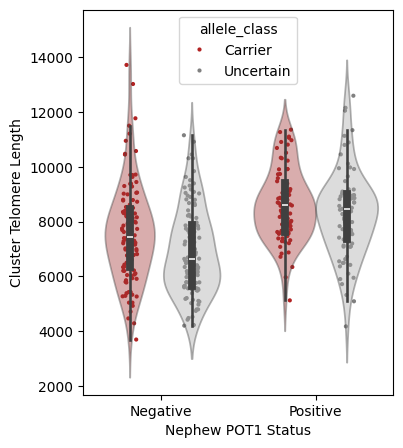

Negative Nephews, Carrier vs Uncertain alleles Welch's T-statistic: 3.0229147069186717, P-value: 0.0027929535601761914
Positive Nephews, Carrier vs Uncertain alleles Welch's T-statistic: 1.4046539259137394, P-value: 0.16213266453572317
Carrier Alleles, Positive vs Negative nephews Welch's T-statistic: -4.599593553611124, P-value: 7.817379512839872e-06
Uncertain Alleles, Positive vs Negative nephews Welch's T-statistic: -6.089930253629613, P-value: 7.0761610779669335e-09
Negative Nephews Carrier Allele Median of 75pct cluster telomere length: 7452.375
Negative Nephews Uncertain Allele Median of 75pct cluster telomere length: 6638.0
Positive Nephews Carrier Allele Median of 75pct cluster telomere length: 8587.75
Positive Nephews Uncertain Allele Median of 75pct cluster telomere length: 8449.5


In [48]:
file_prefix = 'fam1_nephew_len_violin'

fig,ax = plt.subplots(figsize = (4,5))
i=sns.violinplot(data=plot_sibling_df,x='caPOT1_status',y=f'{operator_for_average}_tel_len',hue='allele_class',
               palette=['firebrick','darkgrey'],alpha=0.4,legend=False)
j=sns.stripplot(data=plot_sibling_df,x='caPOT1_status',y=f'{operator_for_average}_tel_len',hue='allele_class',
              dodge=True,size=3,palette=['firebrick','grey'],zorder=0)
ax.set_xlabel('Nephew POT1 Status')
ax.set_ylabel('Cluster Telomere Length')

plt.show()
fig.savefig(figure_dir/f'{file_prefix}.png',bbox_inches='tight')
fig.savefig(figure_dir/f'{file_prefix}_transparent.png',bbox_inches='tight',transparent=True)
svg_path = figure_dir/f'{file_prefix}.svg'
ai_path = figure_dir/f'{file_prefix}.ai'
plt.rcParams['svg.fonttype'] = 'none'
# Save the figure as an SVG file
fig.savefig(svg_path, format="svg",bbox_inches='tight')
# Convert the SVG file to AI format
cairosvg.svg2pdf(url=str(svg_path), write_to=str(ai_path))
plt.close()

# calculate t-test stats
with open(figure_dir/f'{file_prefix}_ttest_stats.txt', 'w') as f:
    for nephew_status in ['Negative','Positive']:
        tdf = plot_sibling_df[plot_sibling_df.caPOT1_status==nephew_status]
        carrier_allele_data = tdf[tdf['allele_class']=='Carrier'][f'{operator_for_average}_tel_len']
        nonc_allele_data = tdf[tdf['allele_class']=='Uncertain'][f'{operator_for_average}_tel_len']
        t_statistic_welch, p_value_welch = stats.ttest_ind(carrier_allele_data, nonc_allele_data, equal_var=False)
        print(f"{nephew_status} Nephews, Carrier vs Uncertain alleles Welch's T-statistic: {t_statistic_welch}, P-value: {p_value_welch}")
        f.write(f"{nephew_status} Nephews, Carrier vs Uncertain alleles Welch's T-statistic: {t_statistic_welch}, P-value: {p_value_welch}\n")

    for allele_class in ['Carrier','Uncertain']:
        tdf = plot_sibling_df[plot_sibling_df.allele_class==allele_class]
        neg_neph_data = tdf[tdf['caPOT1_status']=='Negative'][f'{operator_for_average}_tel_len']
        pos_neph_data = tdf[tdf['caPOT1_status']=='Positive'][f'{operator_for_average}_tel_len']
        t_statistic_welch, p_value_welch = stats.ttest_ind(neg_neph_data, pos_neph_data, equal_var=False)
        print(f"{allele_class} Alleles, Positive vs Negative nephews Welch's T-statistic: {t_statistic_welch}, P-value: {p_value_welch}")
        f.write(f"{allele_class} Alleles, Positive vs Negative nephews Welch's T-statistic: {t_statistic_welch}, P-value: {p_value_welch}\n")
    for (status,allele_class) in [(x,y) for x in ['Negative','Positive'] for y in ['Carrier','Uncertain']]:
        median_stat = plot_sibling_df[plot_sibling_df['plot_category']==f'{allele_class}+{status}'][f'{operator_for_average}_tel_len'].median()
        print(f'{status} Nephews {allele_class} Allele Median of {operator_for_average} cluster telomere length: {median_stat}')
        f.write(f'{status} Nephews {allele_class} Allele Median of {operator_for_average} cluster telomere length: {median_stat}\n')

In [24]:
fc_nephews_df = []
counter = 0
for allele_id in unique(plot_sibling_df.allele_id.tolist()):
    delta_temp_df = pd.DataFrame()
    allele_type = unique(plot_sibling_df[plot_sibling_df.allele_id==allele_id].allele_class.tolist())
    if len(allele_type)!=1:
        print(f'Issue with allele classification for allele id:{allele_id}')
        continue
    allele_type = allele_type[0]
    tdf = plot_sibling_df[plot_sibling_df.allele_id==allele_id]
    neg_nephew_lens = tdf[tdf['caPOT1_status']=='Negative'][f'{operator_for_average}_tel_len'].tolist()
    pos_nephew_lens = tdf[tdf['caPOT1_status']=='Positive'][f'{operator_for_average}_tel_len'].tolist()
    if len(neg_nephew_lens)==0 or len(pos_nephew_lens)==0:
        continue
    fc = [x/y for x in pos_nephew_lens for y in neg_nephew_lens]
    l2fc = [np.log2(x) for x in fc]
    delta_temp_df['fold_change_pos_vs_neg'] = fc
    delta_temp_df['log2_fc_pos_vs_neg'] = l2fc
    delta_temp_df['allele_class'] = allele_type
    delta_temp_df['plot_allele_id'] = allele_id

    fc_nephews_df.append(delta_temp_df)
fc_nephews_df = pd.concat(fc_nephews_df).reset_index()

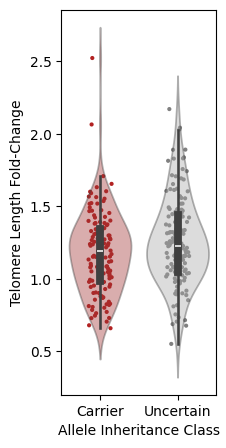

Welch's T-statistic: -2.1098039107277646, P-value: 0.035823525426676675
Median Fold-Change in Carrier Alleles: 1.1931385006353241
Median Fold-Change in Uncertain Alleles: 1.2287253564393805


In [ ]:
file_prefix = 'fam1_nephew_tel_len_fc'
fig,ax = plt.subplots(figsize = (2,5))

i=sns.violinplot(data=fc_nephews_df,x='allele_class',y='fold_change_pos_vs_neg',hue='allele_class',hue_order=['Carrier','Uncertain'],
               palette=['firebrick','darkgrey'],alpha=0.4,legend=False)
j=sns.stripplot(data=fc_nephews_df,x='allele_class',y='fold_change_pos_vs_neg',hue='allele_class',hue_order=['Carrier','Uncertain'],
              dodge=False,jitter=0.15,size=3,palette=['firebrick','grey'],zorder=0)
ax.set_xlabel('Allele Inheritance Class')
ax.set_ylabel('Telomere Length Fold-Change')

plt.show()
fig.savefig(figure_dir/f'{file_prefix}.png',bbox_inches='tight')
fig.savefig(figure_dir/f'{file_prefix}_transparent.png',bbox_inches='tight',transparent=True)
svg_path = figure_dir/f'{file_prefix}.svg'
ai_path = figure_dir/f'{file_prefix}.ai'
plt.rcParams['svg.fonttype'] = 'none'
# Save the figure as an SVG file
fig.savefig(svg_path, format="svg",bbox_inches='tight')
# Convert the SVG file to AI format
cairosvg.svg2pdf(url=str(svg_path), write_to=str(ai_path))
plt.close()

group1 = fc_nephews_df[fc_nephews_df['allele_class']=='Carrier']['fold_change_pos_vs_neg'].tolist()
group2 = fc_nephews_df[fc_nephews_df['allele_class']=='Uncertain']['fold_change_pos_vs_neg'].tolist()
t_statistic_welch, p_value_welch = stats.ttest_ind(group1, group2, equal_var=False)
print(f"Welch's T-statistic: {t_statistic_welch}, P-value: {p_value_welch}")
with open(figure_dir/f'{file_prefix}_ttest_stats.txt','w') as f:
    f.write(f"Welch's T-statistic: {t_statistic_welch}, P-value: {p_value_welch}")
    for allele_class in ['Carrier','Uncertain']:
        median_stat = fc_nephews_df[fc_nephews_df['allele_class']==allele_class]['fold_change_pos_vs_neg'].median()
        print(f'Median Fold-Change in {allele_class} Alleles: {median_stat}')
        f.write(f'Median Fold-Change in {allele_class} Alleles: {median_stat}\n')

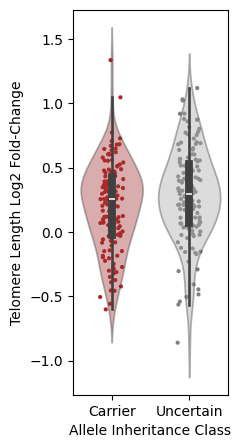

Welch's T-statistic: -2.023025781405407, P-value: 0.04408307972695195
Median Log2 Fold-Change in Carrier Alleles: 0.2547615221462882
Median Log2 Fold-Change in Uncertain Alleles: 0.29715945054032905


In [58]:
file_prefix = 'fam1_nephew_tel_len_log2fc'
fig,ax = plt.subplots(figsize = (2,5))

i=sns.violinplot(data=fc_nephews_df,x='allele_class',y='log2_fc_pos_vs_neg',hue='allele_class',hue_order=['Carrier','Uncertain'],
               palette=['firebrick','darkgrey'],alpha=0.4,legend=False)
j=sns.stripplot(data=fc_nephews_df,x='allele_class',y='log2_fc_pos_vs_neg',hue='allele_class',hue_order=['Carrier','Uncertain'],
              dodge=False,jitter=0.15,size=3,palette=['firebrick','grey'],zorder=0)
ax.set_xlabel('Allele Inheritance Class')
ax.set_ylabel('Telomere Length Log2 Fold-Change')

plt.show()
fig.savefig(figure_dir/f'{file_prefix}.png',bbox_inches='tight')
fig.savefig(figure_dir/f'{file_prefix}_transparent.png',bbox_inches='tight',transparent=True)
svg_path = figure_dir/f'{file_prefix}.svg'
ai_path = figure_dir/f'{file_prefix}.ai'
plt.rcParams['svg.fonttype'] = 'none'
# Save the figure as an SVG file
fig.savefig(svg_path, format="svg",bbox_inches='tight')
# Convert the SVG file to AI format
cairosvg.svg2pdf(url=str(svg_path), write_to=str(ai_path))
plt.close()

group1 = fc_nephews_df[fc_nephews_df['allele_class']=='Carrier']['log2_fc_pos_vs_neg'].tolist()
group2 = fc_nephews_df[fc_nephews_df['allele_class']=='Uncertain']['log2_fc_pos_vs_neg'].tolist()
t_statistic_welch, p_value_welch = stats.ttest_ind(group1, group2, equal_var=False)
print(f"Welch's T-statistic: {t_statistic_welch}, P-value: {p_value_welch}")
with open(figure_dir/f'{file_prefix}_ttest_stats.txt','w') as f:
    f.write(f"Welch's T-statistic: {t_statistic_welch}, P-value: {p_value_welch}")
    for allele_class in ['Carrier','Uncertain']:
        median_stat = fc_nephews_df[fc_nephews_df['allele_class']==allele_class]['log2_fc_pos_vs_neg'].median()
        print(f'Median Log2 Fold-Change in {allele_class} Alleles: {median_stat}')
        f.write(f'Median Log2 Fold-Change in {allele_class} Alleles: {median_stat}\n')

In [ ]:
carrier_siblings = siblings_key[siblings_key['caPOT1Status']=='+']['Sample'].tolist()
non_carrier_siblings = siblings_key[siblings_key['caPOT1Status']=='-']['Sample'].tolist()

negative_df = plot_sibling_df[plot_sibling_df['caPOT1_status']=='Negative'].groupby('allele_id').mean(numeric_only=True)
negative_df = negative_df.rename(columns={f'{operator_for_average}_tel_len':f'negative_{operator_for_average}_tel_len'})
positive_df = plot_sibling_df[plot_sibling_df['caPOT1_status']=='Positive'].groupby('allele_id').mean(numeric_only=True)
positive_df = positive_df.rename(columns={f'{operator_for_average}_tel_len':f'positive_{operator_for_average}_tel_len'})
averages_df = pd.concat([negative_df,positive_df],axis=1).dropna()
averages_df.reset_index(inplace=True)
averages_df['allele_class'] = averages_df.allele_id.apply(lambda x:sibling_df[sibling_df['plot_allele_id']==x]['allele_class'].item())
averages_df['fold_change_pos_over_neg'] = averages_df[f'positive_{operator_for_average}_tel_len']/averages_df[f'negative_{operator_for_average}_tel_len']
averages_df


,allele_id,negative_75pct_tel_len,positive_75pct_tel_len,allele_class,fold_change_pos_over_neg
0,8,5824.250,8129.875,Carrier,1.395866
1,11,5564.750,7577.250,Carrier,1.361651
2,15,5599.875,8240.500,Carrier,1.471551
3,17,8361.000,9055.000,Carrier,1.083004
4,18,5424.750,7671.000,Carrier,1.414074
...,...,...,...,...,...
109,233,8184.000,8816.250,Uncertain,1.077254
110,239,5381.000,5088.500,Uncertain,0.945642
111,244,9045.750,8136.250,Uncertain,0.899456
112,245,5206.500,6548.000,Uncertain,1.257659


In [87]:
group1 = averages_df[averages_df['allele_class']=='Carrier']['fold_change_pos_over_neg'].tolist()
group2 = averages_df[averages_df['allele_class']=='Uncertain']['fold_change_pos_over_neg'].tolist()
t_statistic_welch, p_value_welch = stats.ttest_ind(group1, group2, equal_var=False)
print(f"Welch's T-statistic: {t_statistic_welch}, P-value: {p_value_welch}")

Welch's T-statistic: -1.3413795367784411, P-value: 0.18254865473161583
